## Data extraction

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.utils import resample

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame, using the first column as the index
data = pd.read_csv("healthcare-dataset-stroke-data-1.csv", index_col='Unnamed: 0')

## EDA

In [4]:
data.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1.0,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0.0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1.0,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0.0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0.0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0.0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1.0,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0.0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0.0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0.0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5010 non-null   float64
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5023 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 519.0+ KB


In [6]:
data.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5010.000000,5110,5110,5023,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2554,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054890,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.227789,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [7]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease        100
ever_married           0
work_type              0
Residence_type        87
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Null values are in categorical and numerical atributes.

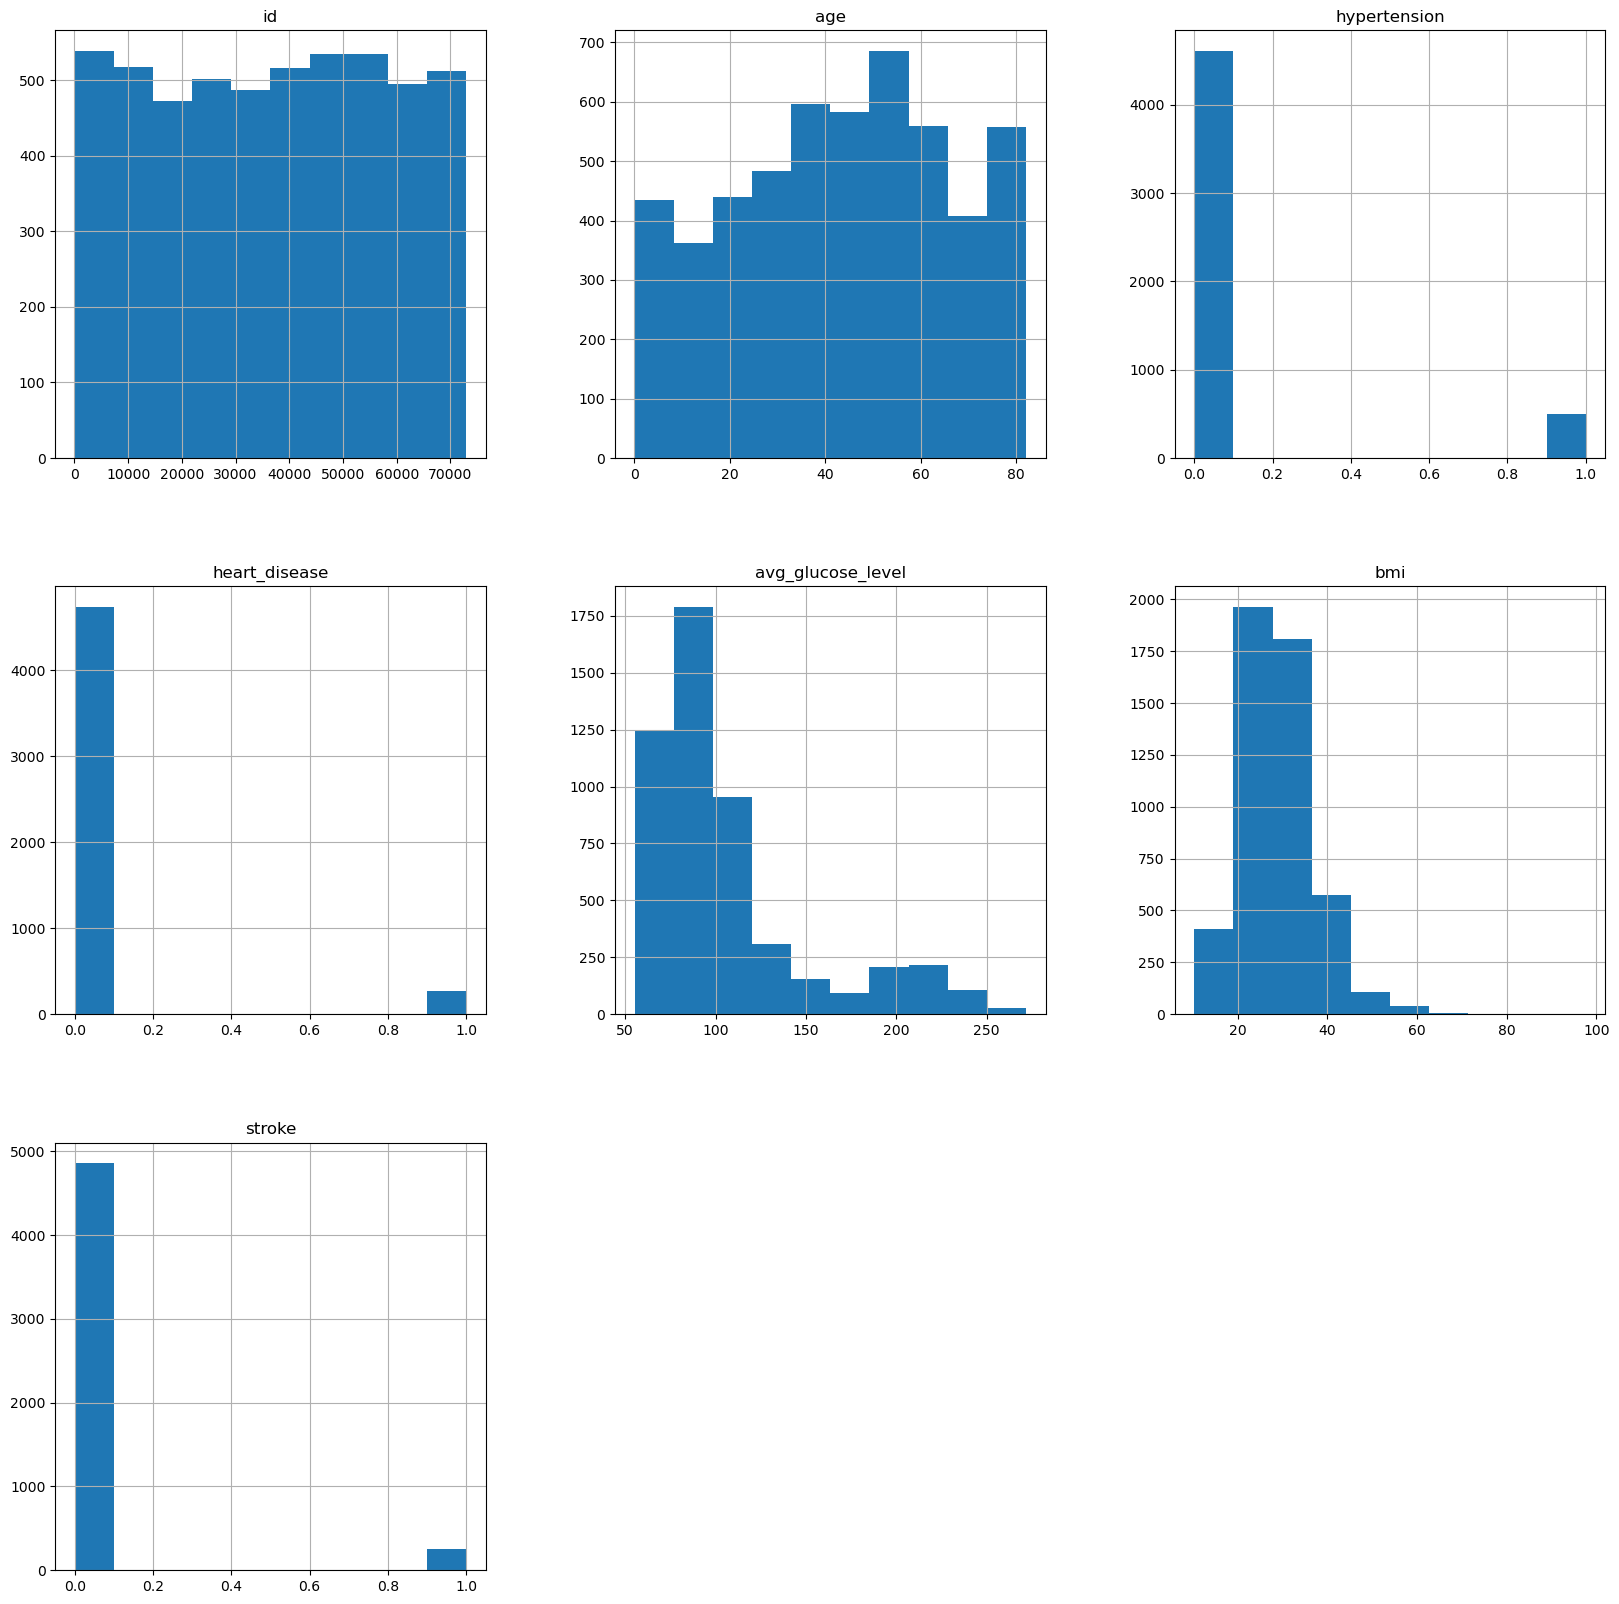

In [8]:
data.hist(figsize = (20, 20))
plt.show()

All numerical attributes have different scales; they should be scaled accordinly.

The age distribution exhibits several peaks, indicating a need for inspection after data cleaning.The distributions of 'avg_glucose_level' and 'bmi' are skewed to the left, with means of 106.147677 and 28.893237, respectively.These should also be inspected for possible correction of the distution.

The dataset is imbalanced, with a significantly higher number of samples without stroke compared to those with stroke. This imbalance is also evident in the 'hypertension' and 'heart_disease' columns. Let's check the percentage of strokes in the data set.

In [9]:
stroke_counts = data['stroke'].value_counts()
stroke_percentages = stroke_counts / len(data) * 100
stroke_percentages

stroke
0    95.127202
1     4.872798
Name: count, dtype: float64

Stroke represents only 5% of all samples. Therefore, the dataset should be upscaled for future model learning.

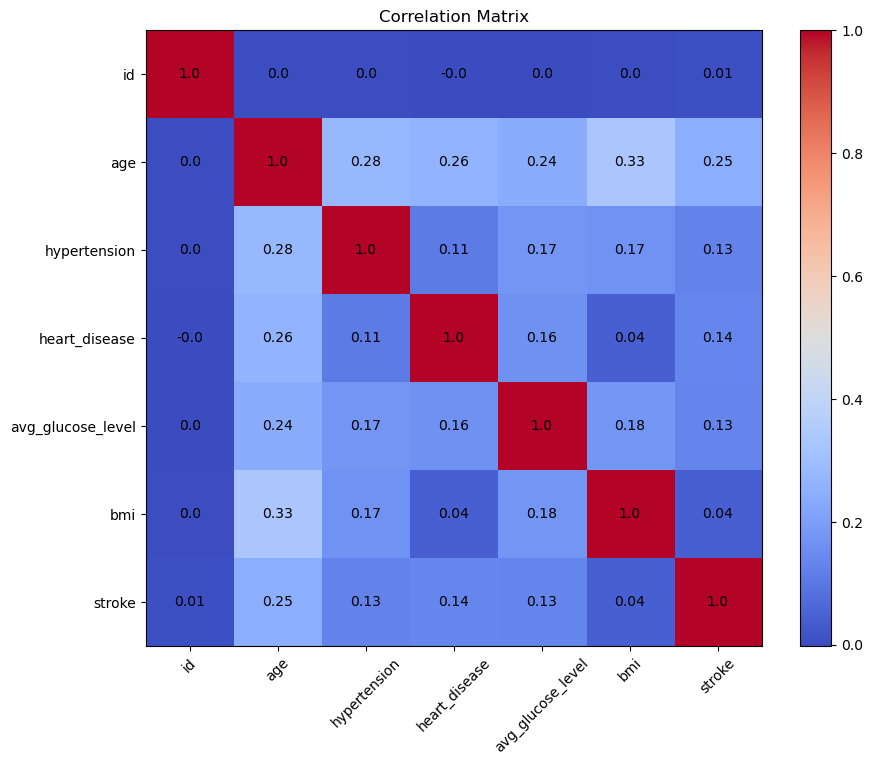

In [10]:
# Select numerical columns from the DataFrame
numeric_df = data.select_dtypes(include=['int64', 'float64'])
# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

# Add correlation coefficient values as annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, round(correlation_matrix.iloc[i, j], 2), ha='center', va='center', color='black')

plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

The 'Id' column does not correlate with others. It could be removed from the dataset without affecting model training.

In [11]:
data.drop('id',axis=1,inplace=True)

### Detail exploration of data
Notes: The Seaborn package is not included in the comsci714 environment. To avoid possible errors, all visualizations were performed using Matplotlib.

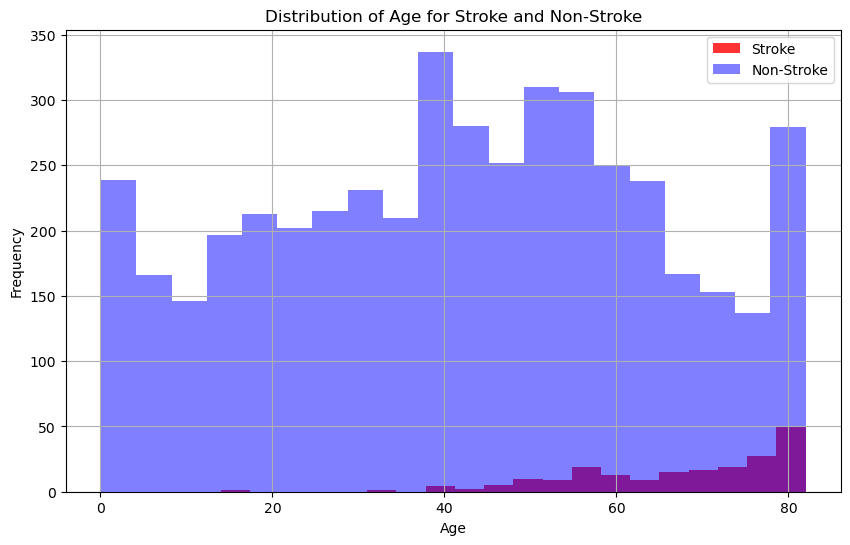

In [12]:
Stroke_N = data[data['stroke'] == 0].dropna()
Stroke_Y = data[data['stroke'] == 1].dropna()

plt.figure(figsize=(10, 6))
plt.hist(Stroke_Y['age'], bins=20, alpha=0.8, label='Stroke', color='red')
plt.hist(Stroke_N['age'], bins=20, alpha=0.5, label='Non-Stroke', color='blue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age for Stroke and Non-Stroke')
plt.legend()
plt.grid(True)
plt.show()

The number of stroke cases increases with age from the 40s to the 80s.

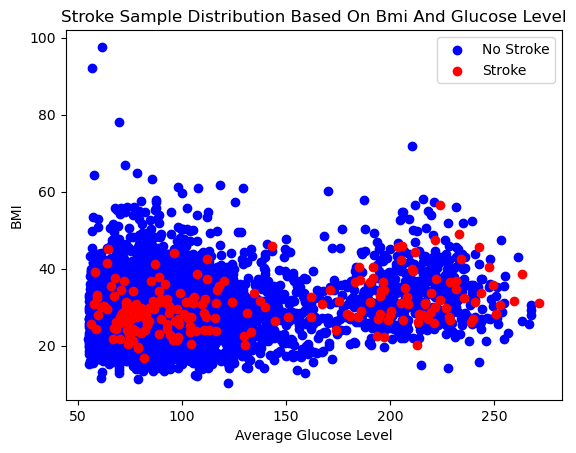

In [13]:
plt.title('Stroke Sample Distribution Based On Bmi And Glucose Level')
plt.scatter(Stroke_N['avg_glucose_level'], Stroke_N['bmi'], label='No Stroke', color='blue')
plt.scatter(Stroke_Y['avg_glucose_level'], Stroke_Y['bmi'], label='Stroke', color='red')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.legend()

Stroke is more likely to occur within the BMI range of 10-40. 
We observe the presence of two clusters based on Glucose Levels: the first cluster falls approximately within the range of 50-150, while the second cluster falls within 150-250. This observation could explain the variations in the distributions. 

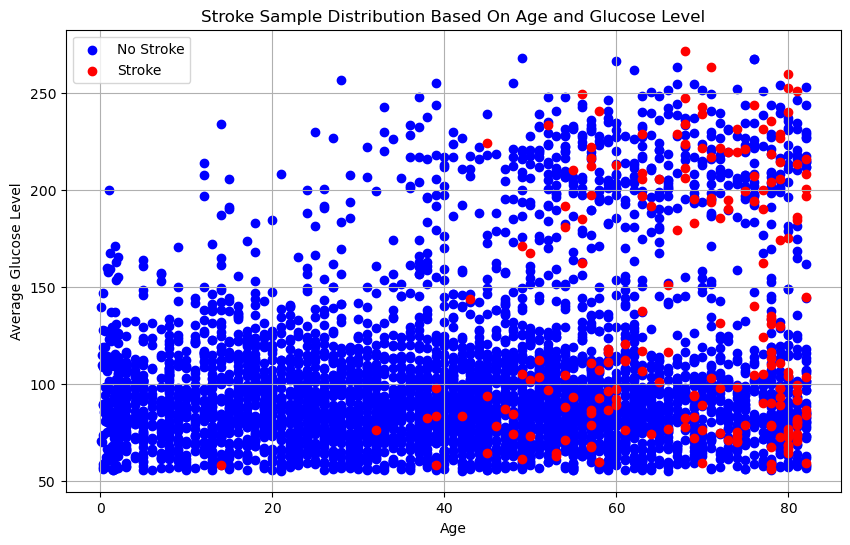

In [14]:
plt.figure(figsize=(10, 6))
plt.title('Stroke Sample Distribution Based On Age and Glucose Level')
plt.scatter(Stroke_N['age'], Stroke_N['avg_glucose_level'], label='No Stroke', color='blue')
plt.scatter(Stroke_Y['age'], Stroke_Y['avg_glucose_level'], label='Stroke', color='red')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend()
plt.grid(True)
plt.show()


The  cluster in the range of glucose 150-200 may represent patients with diabetes.

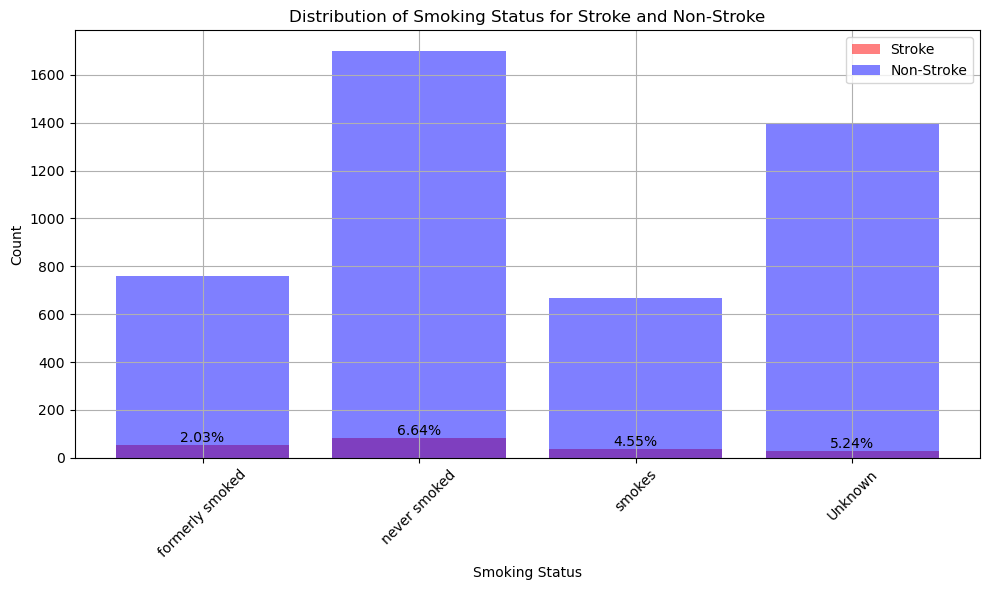

In [15]:
stroke_smoking_count = Stroke_Y['smoking_status'].value_counts()
non_stroke_smoking_count = Stroke_N['smoking_status'].value_counts()

# Get all unique smoking statuses
unique_smoking_status = data['smoking_status'].unique()

# Calculate total counts for each smoking status
total_counts = stroke_smoking_count.add(non_stroke_smoking_count, fill_value=0)

# Calculate percentages
stroke_percentages = (stroke_smoking_count / total_counts) * 100
non_stroke_percentages = (non_stroke_smoking_count / total_counts) * 100

# Create bar plots
plt.figure(figsize=(10, 6))

# Plotting for stroke patients
stroke_bars = plt.bar(unique_smoking_status, stroke_smoking_count.reindex(unique_smoking_status, fill_value=0), alpha=0.5, label='Stroke', color='red')

# Plotting for non-stroke patients
plt.bar(unique_smoking_status, non_stroke_smoking_count.reindex(unique_smoking_status, fill_value=0), alpha=0.5, label='Non-Stroke', color='blue')

# Annotate bars with percentage values only for stroke patients
for bar, percentage in zip(stroke_bars, stroke_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.title('Distribution of Smoking Status for Stroke and Non-Stroke')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

The smoking status does not provide clear evidence of the effect of smoking on stroke. 

The 'Unknown' class comprises around 1500 records, which cannot be dropped or randomly distributed among other classes. 

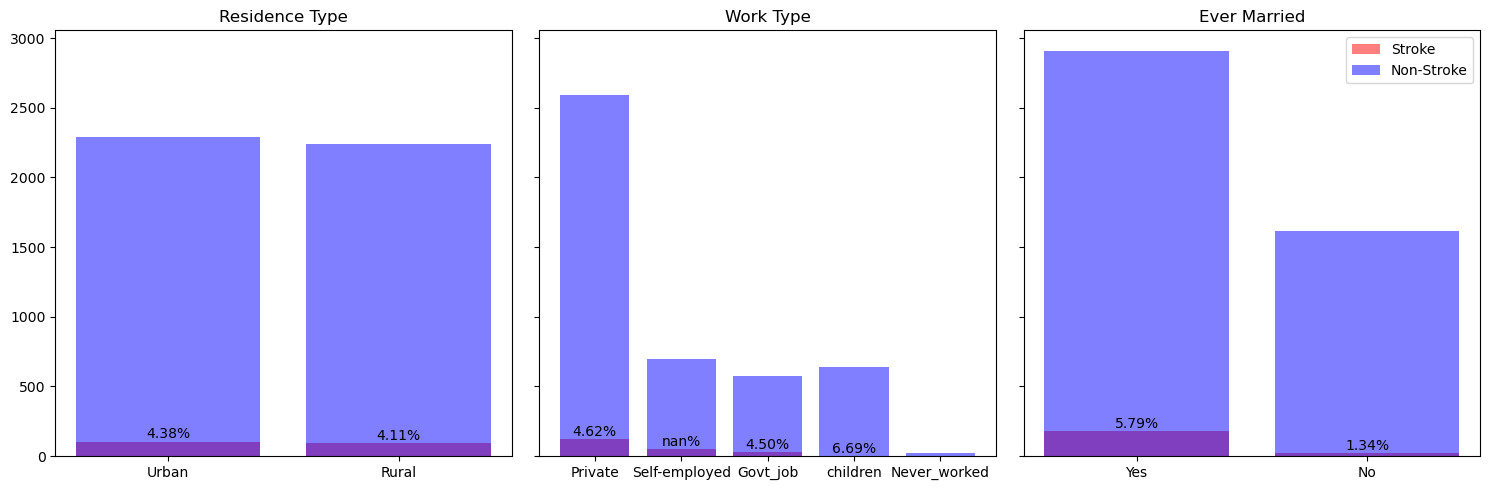

In [16]:
stroke_residence_counts = Stroke_Y['Residence_type'].value_counts()
non_stroke_residence_counts = Stroke_N['Residence_type'].value_counts()

stroke_work_counts = Stroke_Y['work_type'].value_counts()
non_stroke_work_counts = Stroke_N['work_type'].value_counts()

stroke_married_counts = Stroke_Y['ever_married'].value_counts()
non_stroke_married_counts = Stroke_N['ever_married'].value_counts()

# Calculate total counts for each feature
total_residence_counts = stroke_residence_counts.add(non_stroke_residence_counts, fill_value=0)
total_work_counts = stroke_work_counts.add(non_stroke_work_counts, fill_value=0)
total_married_counts = stroke_married_counts.add(non_stroke_married_counts, fill_value=0)

# Calculate stroke percentages
stroke_residence_percentages = (stroke_residence_counts / total_residence_counts) * 100
stroke_work_percentages = (stroke_work_counts / total_work_counts) * 100
stroke_married_percentages = (stroke_married_counts / total_married_counts) * 100

# Plotting the distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Residence_type
stroke_bars_residence = axes[0].bar(stroke_residence_counts.index, stroke_residence_counts, alpha=0.5, label='Stroke', color='red')
axes[0].bar(non_stroke_residence_counts.index, non_stroke_residence_counts, alpha=0.5, label='Non-Stroke', color='blue')
axes[0].set_title('Residence Type')

# Annotate bars with percentage values only for stroke patients
for bar, percentage in zip(stroke_bars_residence, stroke_residence_percentages):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

# Work_type
stroke_bars_work = axes[1].bar(stroke_work_counts.index, stroke_work_counts, alpha=0.5, label='Stroke', color='red')
axes[1].bar(non_stroke_work_counts.index, non_stroke_work_counts, alpha=0.5, label='Non-Stroke', color='blue')
axes[1].set_title('Work Type')

# Annotate bars with percentage values only for stroke patients
for bar, percentage in zip(stroke_bars_work, stroke_work_percentages):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

# Ever_married
stroke_bars_married = axes[2].bar(stroke_married_counts.index, stroke_married_counts, alpha=0.5, label='Stroke', color='red')
axes[2].bar(non_stroke_married_counts.index, non_stroke_married_counts, alpha=0.5, label='Non-Stroke', color='blue')
axes[2].set_title('Ever Married')
axes[2].legend()

# Annotate bars with percentage values only for stroke patients
for bar, percentage in zip(stroke_bars_married, stroke_married_percentages):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Residence type has 2 classes with almost an equal number of stroke and non-stroke records. 
Work type also does not provide a strong prediction; the class is imbalanced and has more records of patients working in the private sector, resulting in more strokes than other classes. The 'Self-employed' class should be thoroughly examined for better analysis. 
The married classe is more than not married, and the former group is more prone to strokes.

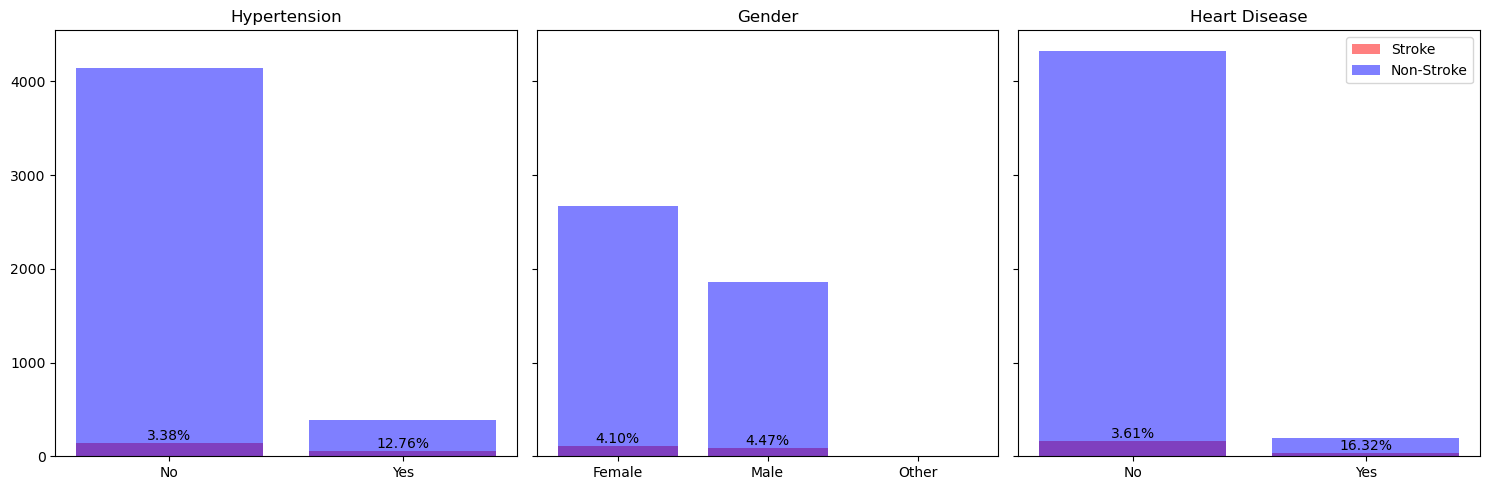

In [17]:
# Calculate counts for stroke and non-stroke groups for each feature
stroke_hypertension_counts = Stroke_Y['hypertension'].value_counts()
non_stroke_hypertension_counts = Stroke_N['hypertension'].value_counts()

stroke_gender_counts = Stroke_Y['gender'].value_counts()
non_stroke_gender_counts =Stroke_N['gender'].value_counts()

stroke_heart_disease_counts = Stroke_Y['heart_disease'].value_counts()
non_stroke_heart_disease_counts = Stroke_N['heart_disease'].value_counts()

# Calculate total counts for each feature
total_hypertension_counts = stroke_hypertension_counts.add(non_stroke_hypertension_counts, fill_value=0)
total_gender_counts = stroke_gender_counts.add(non_stroke_gender_counts, fill_value=0)
total_heart_disease_counts = stroke_heart_disease_counts.add(non_stroke_heart_disease_counts, fill_value=0)

# Calculate stroke percentages
stroke_hypertension_percentages = (stroke_hypertension_counts / total_hypertension_counts) * 100
stroke_gender_percentages = (stroke_gender_counts / total_gender_counts) * 100
stroke_heart_disease_percentages = (stroke_heart_disease_counts / total_heart_disease_counts) * 100

# Plotting the distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Hypertension
stroke_bars_hypertension = axes[0].bar(['No', 'Yes'], stroke_hypertension_counts, alpha=0.5, label='Stroke', color='red')
axes[0].bar(['No', 'Yes'], non_stroke_hypertension_counts, alpha=0.5, label='Non-Stroke', color='blue')
axes[0].set_title('Hypertension')

# Annotate bars with percentage values only for stroke patients
for bar, percentage in zip(stroke_bars_hypertension, stroke_hypertension_percentages):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

# Gender
stroke_bars_gender = axes[1].bar(stroke_gender_counts.index, stroke_gender_counts, alpha=0.5, label='Stroke', color='red')
axes[1].bar(non_stroke_gender_counts.index, non_stroke_gender_counts, alpha=0.5, label='Non-Stroke', color='blue')
axes[1].set_title('Gender')


# Annotate bars with percentage values only for stroke patients
for bar, percentage in zip(stroke_bars_gender, stroke_gender_percentages):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

# Heart Disease
stroke_bars_heart_disease = axes[2].bar(['No', 'Yes'], stroke_heart_disease_counts, alpha=0.5, label='Stroke', color='red')
axes[2].bar(['No', 'Yes'], non_stroke_heart_disease_counts, alpha=0.5, label='Non-Stroke', color='blue')
axes[2].set_title('Heart Disease')
axes[2].legend()

# Annotate bars with percentage values only for stroke patients
for bar, percentage in zip(stroke_bars_heart_disease, stroke_heart_disease_percentages):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Heart disease and hypertension are imbalanced. However, almost one-fifth of patients with heart disease have had a stroke, and more than 13% of patients with hypertension are prone to strokes.

Although there are more females than males, the percentage of strokes is almost equal. Let's explore the gender attribute in more detail.

In [18]:
data['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

The class "Other" contains only one record and could potentially skew the training of the model if left in the dataset. Therefore, it should either be removed from the dataset entirely or isolated from the training set to prevent the model from making inaccurate predictions, as the model could overfit to this single instance.

## Data cleaning. Categorical values

I would like to split the cleaning process and first drop NA Residence_type values because they are categorical values, and real values could be determined by the data owner. Also, assigning random or neighborhood values may lead to bias.

In [19]:
data.dropna(subset=data.select_dtypes(include=['object']).columns, inplace=True)

## Transforming text/categorical attributes to numerical attributes

In [20]:
data_cat = data.select_dtypes(include=[np.object_])

In [21]:
categorical_columns = data_cat.columns.tolist()

# Extract categorical features
cat_features = data[categorical_columns]

# Create OneHotEncoder object
cat_encoder = OneHotEncoder()
cat_encoder.handle_unknown = "ignore"
# Fit and transform the categorical features
encoded_features = cat_encoder.fit_transform(cat_features)

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=cat_encoder.get_feature_names_out(categorical_columns))

# Display the encoded DataFrame
print(encoded_df.head())

   gender_Female  gender_Male  gender_Other  ever_married_No  \
0            0.0          1.0           0.0              0.0   
1            1.0          0.0           0.0              0.0   
2            0.0          1.0           0.0              0.0   
3            1.0          0.0           0.0              0.0   
4            1.0          0.0           0.0              0.0   

   ever_married_Yes  work_type_Govt_job  work_type_Never_worked  \
0               1.0                 0.0                     0.0   
1               1.0                 0.0                     0.0   
2               1.0                 0.0                     0.0   
3               1.0                 0.0                     0.0   
4               1.0                 0.0                     0.0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                1.0                      0.0                 0.0   
1                0.0                      1.0                 0.0   
2    

In [22]:
data_numeric = data.drop(columns=categorical_columns)

# Concatenate the encoded DataFrame with the numerical columns from the original DataFrame
merged_data = pd.concat([data_numeric.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Display the merged DataFrame
merged_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1.0,228.69,36.6,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,61.0,0,0.0,202.21,NaN,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0,1.0,105.92,32.5,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0,0.0,171.23,34.4,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,79.0,1,0.0,174.12,24.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Split data to features and the target variable sets

In [23]:
X = merged_data.drop('stroke', axis=1)
y = merged_data['stroke']

## Data cleaning. Numerical values

In [24]:
X.isnull().sum()

age                                 0
hypertension                        0
heart_disease                      99
avg_glucose_level                   0
bmi                               197
gender_Female                       0
gender_Male                         0
gender_Other                        0
ever_married_No                     0
ever_married_Yes                    0
work_type_Govt_job                  0
work_type_Never_worked              0
work_type_Private                   0
work_type_Self-employed             0
work_type_children                  0
Residence_type_Rural                0
Residence_type_Urban                0
smoking_status_Unknown              0
smoking_status_formerly smoked      0
smoking_status_never smoked         0
smoking_status_smokes               0
dtype: int64

KNNImputer can be a good choice for imputing missing values in this dataset, especially considering its ability to handle numeric and binary features and capture non-linear relationships between features.

In [25]:
knn_imp = KNNImputer(n_neighbors=5)
X_imputed = knn_imp.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

In [26]:
#Checking results
X_imputed_df.isnull().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Female                     0
gender_Male                       0
gender_Other                      0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

## Feature engineering

Let's add new feature Glucose level to MBI:

In [27]:
X_imputed_df["Glucose level to MBI"] = X_imputed_df["avg_glucose_level"]/X_imputed_df["bmi"]

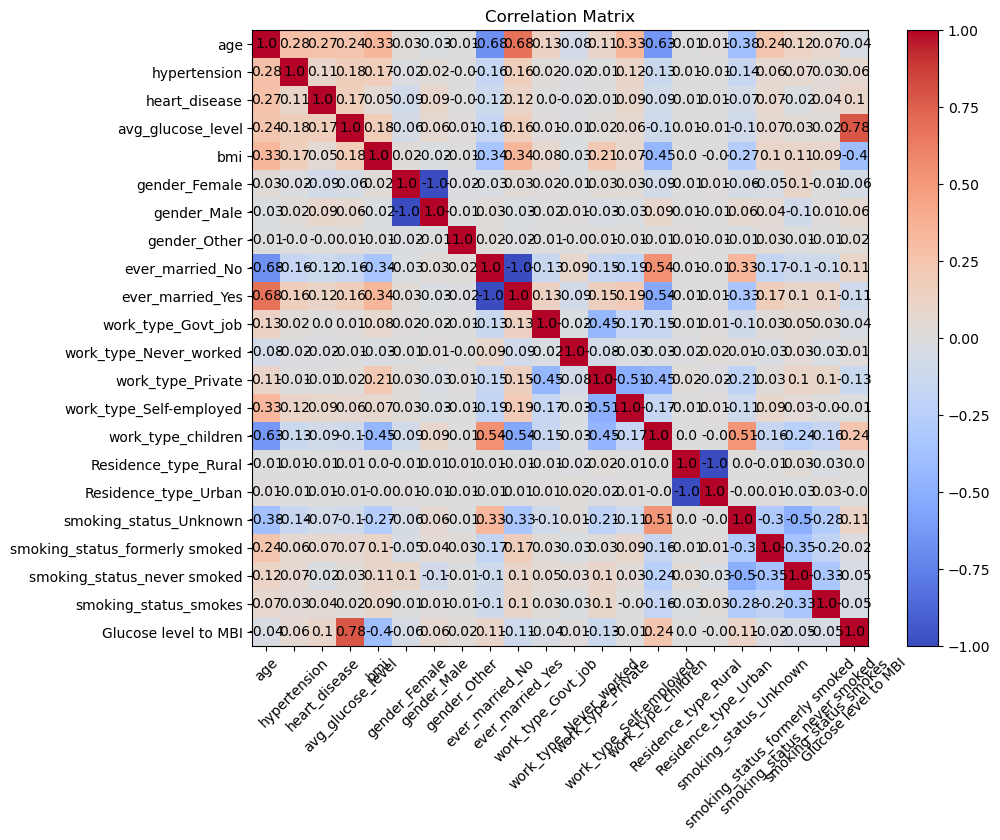

In [29]:
correlation_matrix = X_imputed_df.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

# Add correlation coefficient values as annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, round(correlation_matrix.iloc[i, j], 2), ha='center', va='center', color='black')

plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

New feature is correlated with others and could be used in model training.

## Split data to train and test sets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)

## Removing outliers

For presented high-dimensional dataset, Isolation Forest will be a good chose to remove outliers 

In [31]:
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X_train)

In [32]:
X_train = X_train.iloc[outlier_pred == 1]
y_train = y_train.iloc[outlier_pred == 1]

In [34]:
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Glucose level to MBI
3996,2.0,0.0,0.0,89.32,17.2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.193023
3858,18.0,0.0,0.0,118.93,22.4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.309375
1491,27.0,0.0,0.0,73.00,20.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.650000
88,74.0,0.0,0.0,98.55,25.6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.849609
457,69.0,0.0,0.0,101.52,26.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.788060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,33.0,0.0,0.0,121.19,22.1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.483710
2433,38.0,0.0,0.0,100.02,28.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.572143
1685,33.0,0.0,0.0,124.01,22.7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.462996
2919,54.0,0.0,0.0,97.61,32.1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.040810


In [35]:
y_train

3996    0
3858    0
1491    0
88      1
457     0
       ..
1184    0
2433    0
1685    0
2919    0
860     0
Name: stroke, Length: 2099, dtype: int64

# Scaling

In [36]:
# Define the columns to be scaled
columns_to_scale = ['age', 'avg_glucose_level', 'bmi', "Glucose level to MBI"]

# Create a ColumnTransformer to scale only the specified columns
scaler = ColumnTransformer([
    ('scaler', StandardScaler(), columns_to_scale)
], remainder='passthrough')  # Remainder will keep the other columns unchanged

# Fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set (using the scaler fitted on the training set)
X_test_scaled = scaler.transform(X_test)

In [37]:
X_train_scaled

array([[-1.82512642, -0.12611169, -1.62865788, ...,  0.        ,
         0.        ,  0.        ],
       [-1.04767226,  0.94039976, -0.84742683, ...,  0.        ,
         1.        ,  0.        ],
       [-0.6103543 , -0.71393563, -1.20799501, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.31880899,  1.12337437, -0.80235581, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7015996 ,  0.1724827 ,  0.60986955, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.9649626 , -1.29059379, -0.20140885, ...,  0.        ,
         1.        ,  0.        ]])

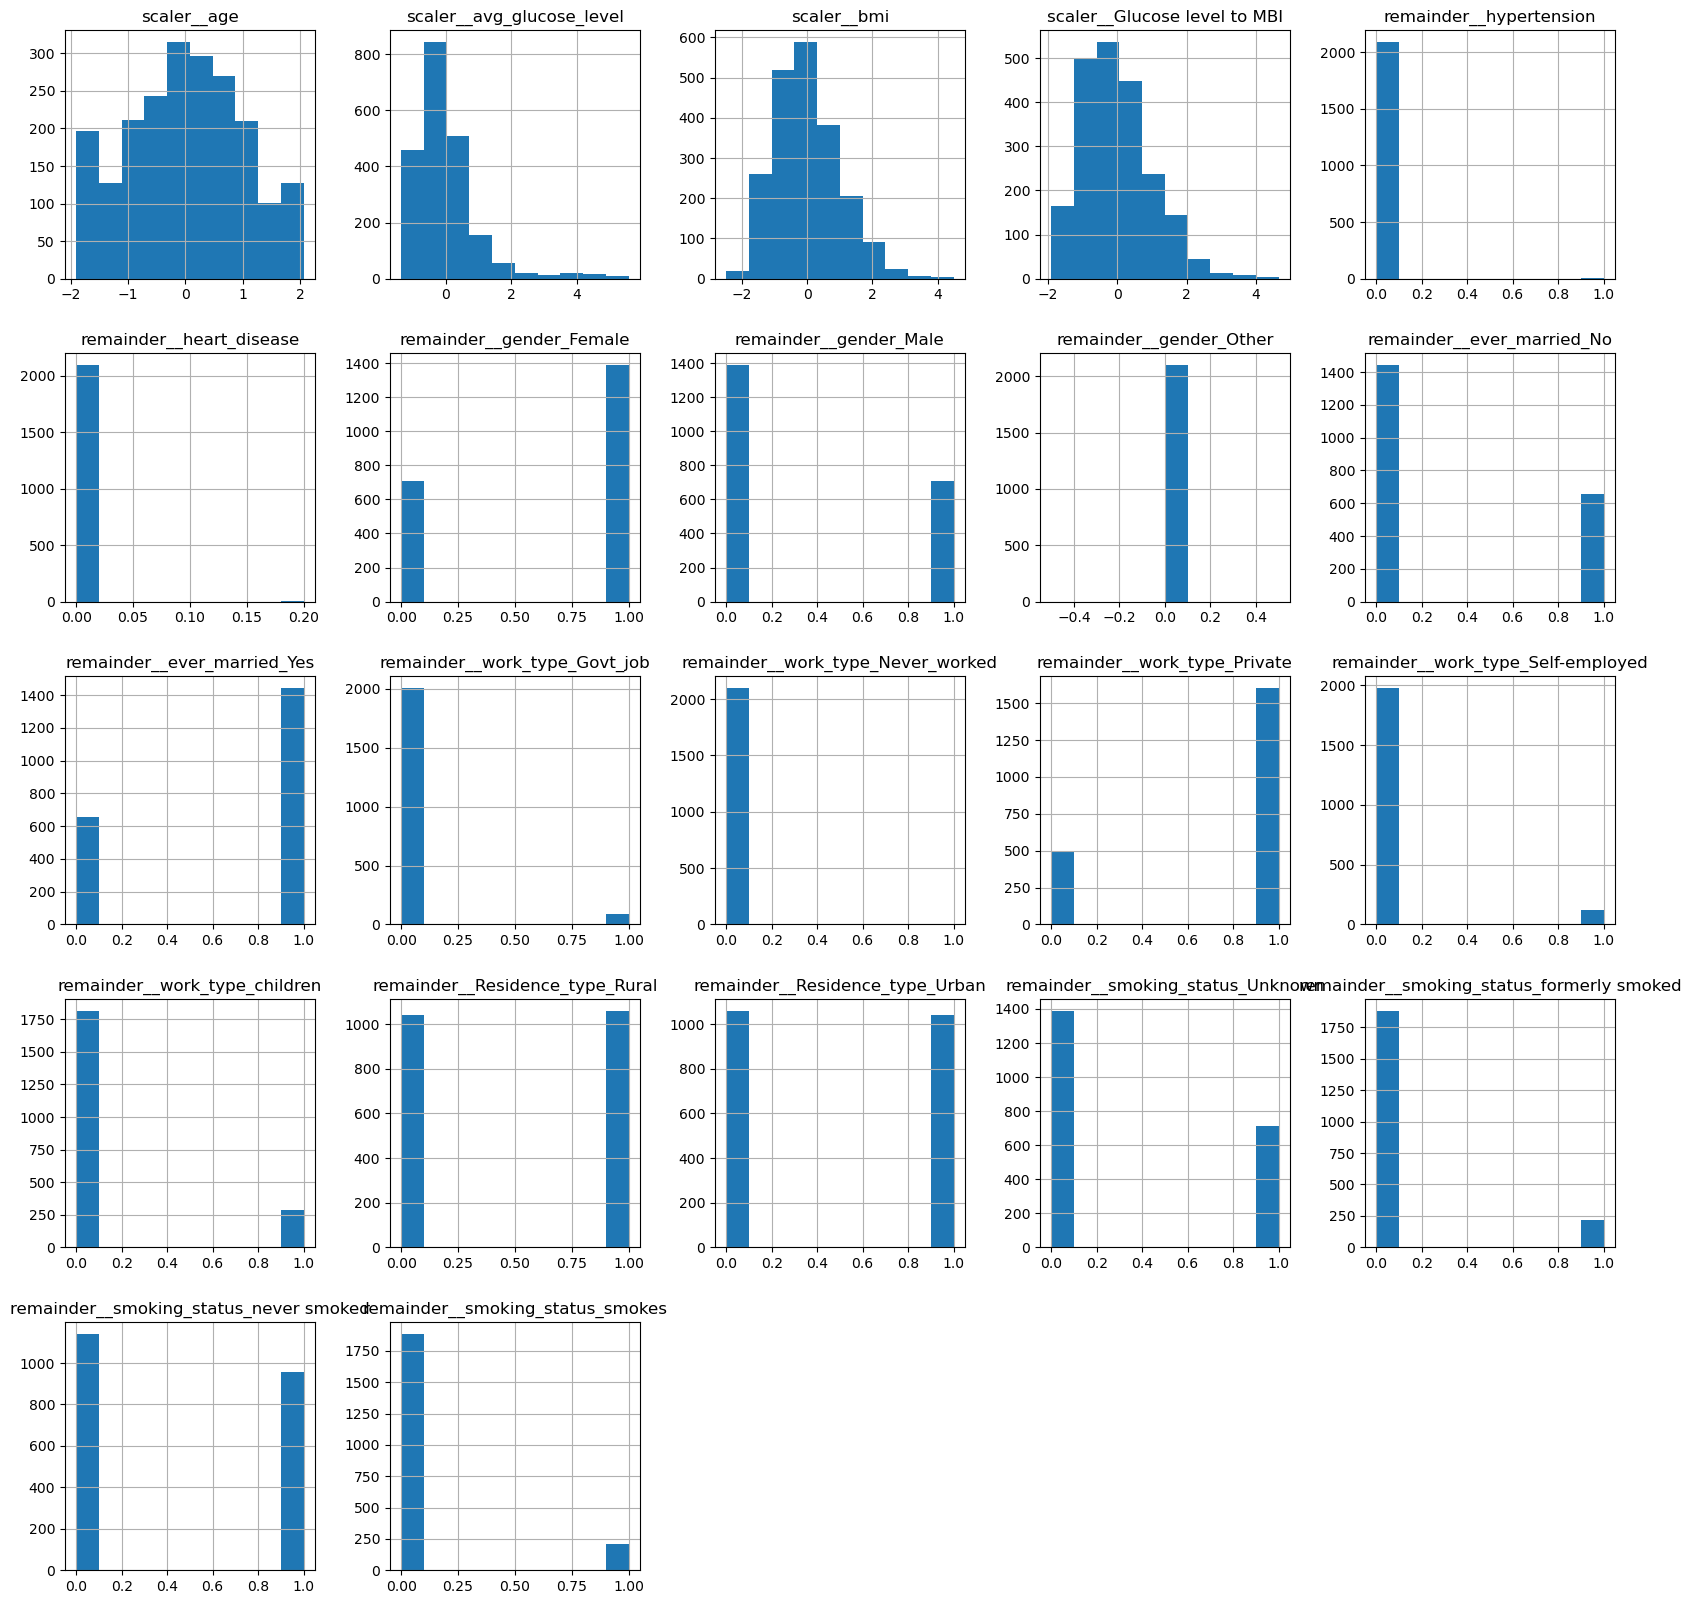

In [38]:
feature_names = scaler.get_feature_names_out()

# Create DataFrame with transformed data
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)
# Plot histograms
df_X_train_scaled.hist(figsize=(20, 20))
plt.show()

## Data distribution transformation

The distributions of avg_glucose_level and bmi are left-skewed. Let's attempt to normalize the distributions using the KMeans approach. We are aware that there are two clusters that could be deremin in the presented dataset. 

In [39]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=2, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [40]:
cluster_simil = ClusterSimilarity(n_clusters=2, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(df_X_train_scaled[['scaler__avg_glucose_level', 'scaler__bmi']],
                                           sample_weight=y_train)

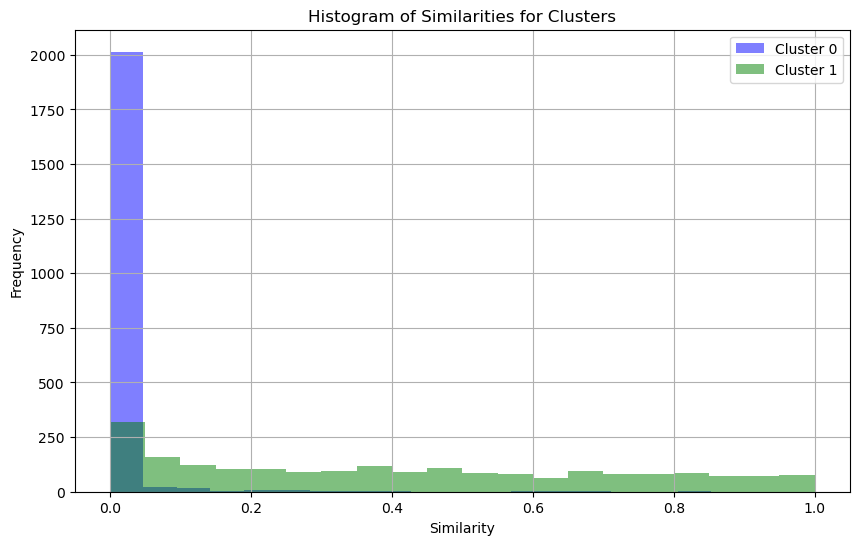

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(similarities[:, 0], bins=20, alpha=0.5, label='Cluster 0', color='blue')
plt.hist(similarities[:, 1], bins=20, alpha=0.5, label='Cluster 1', color='green')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Similarities for Clusters')
plt.legend()
plt.grid(True)
plt.show()

The K-means approach does not yield satisfactory results due to its sensitivity to initial centroid selection and its assumption of isotropic clusters, which may not hold true for our dataset's complex structure.

Let's apply a logarithmic transformer to 'scaler__avg_glucose_level'.

In [42]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(df_X_train_scaled[['scaler__avg_glucose_level']])

C:\Users\Vlad\anaconda3\envs\comsci714\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


array([[<Axes: title={'center': 'scaler__avg_glucose_level'}>]],
      dtype=object)

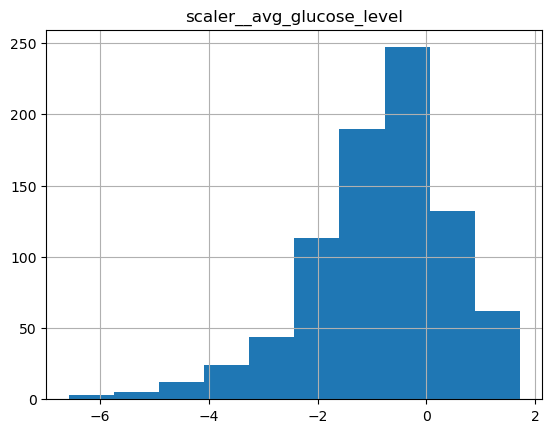

In [43]:
log_pop.hist()

In [44]:
log_pop.isna().sum()

scaler__avg_glucose_level    1267
dtype: int64

The result is still unsatisfactory, and furthermore, we have noticed the presence of NaN values after the transformation

### Class balancing

As only 5% of all data consists of stroke cases, the data should be upsampled to balance the classes. In this work, I will use the sklearn resample method, which requires concatenating features and the target variable for upscaling and then separating them again.

In [45]:
#An alternative technique is SMOTE; however, imblearn library is not installed in the CAMSCI714 environment. 
#sm = SMOTE(random_state=2)
#X_train_res, y_train_res = sm.fit_resample(df_X_train_scaled, y_train.ravel())

In [46]:
train_data = pd.concat([df_X_train_scaled, y_train], axis=1)
train_data

,scaler__age,scaler__avg_glucose_level,scaler__bmi,scaler__Glucose level to MBI,remainder__hypertension,remainder__heart_disease,remainder__gender_Female,remainder__gender_Male,remainder__gender_Other,remainder__ever_married_No,remainder__ever_married_Yes,remainder__work_type_Govt_job,remainder__work_type_Never_worked,remainder__work_type_Private,remainder__work_type_Self-employed,remainder__work_type_children,remainder__Residence_type_Rural,remainder__Residence_type_Urban,remainder__smoking_status_Unknown,remainder__smoking_status_formerly smoked,remainder__smoking_status_never smoked,remainder__smoking_status_smokes,stroke
3996,-1.825126,-0.126112,-1.628658,1.584586,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0
3858,-1.047672,0.940400,-0.847427,1.690428,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1491,-0.610354,-0.713936,-1.207995,0.180941,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
88,1.673417,0.206340,-0.366669,0.362520,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
457,1.430463,0.313316,-0.186385,0.306530,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,-0.318809,1.021802,-0.892498,1.849016,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
2433,-0.075855,0.259288,-0.006101,0.110116,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1685,-0.318809,1.123374,-0.802356,1.830173,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
2919,0.701600,0.172483,0.609870,-0.373222,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [47]:
# Combine X_train and y_train into one DataFrame
train_data = pd.concat([df_X_train_scaled, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['stroke'] == 0]
minority_class = train_data[train_data['stroke'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class, 
                               replace=True,     # Sample with replacement
                               n_samples=len(majority_class),    # Match the number of samples in the majority class
                               random_state=42)  # For reproducible results

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([majority_class, minority_upsampled], axis=0)

# Separate features and target variable in upsampled data
X_train_upsampled = upsampled_data.drop('stroke', axis=1)
y_train_upsampled = upsampled_data['stroke']

# Display the class distribution
y_train_upsampled.value_counts()

stroke
0    2039
1    2039
Name: count, dtype: int64

## Create a pipeline.

This pipeline consists of several steps for data preprocessing and cleaning:

1. **Drop NA Values**: Removes rows with missing values in columns of object type.
2. **One-Hot Encoding**: Encodes categorical features using one-hot encoding, handling unknown categories.
3. **Imputation**: Imputes missing values using KNNImputer with 5 nearest neighbors.
4. **Outliers Removal**: Removes outliers using Isolation Forest algorithm.

In [48]:
pipeline = Pipeline([
    # Drop NA values in object columns
    ('drop_na', FunctionTransformer(lambda X: X.dropna(subset=X.select_dtypes(include=['object']).columns), validate=False)),
    
    # One-hot encode categorical features
    ('encode_cat', ColumnTransformer([
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), selector(dtype_include='object'))
    ], remainder='passthrough')),
    
    # Impute missing values using KNN
    ('impute', KNNImputer(n_neighbors=5)),
    
    # Remove outliers using Isolation Forest
    ('remove_outliers', FunctionTransformer(lambda data: data[np.array(IsolationForest(random_state=42).fit_predict(data[:, :-1])) == 1], validate=False))
])
    
# Fit the pipeline
pipeline.fit(data)

Pipeline(steps=[('drop_na',
                 FunctionTransformer(func=<function <lambda> at 0x0000021BB2F6C310>)),
                ('encode_cat',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021BB011E140>)])),
                ('impute', KNNImputer()),
                ('remove_outliers',
                 FunctionTransformer(func=<function <lambda> at 0x0000021BB01BE8C0>))])

In [49]:
data_prepared = pipeline.fit_transform(data)
data_prepared.shape

(2426, 22)

In [50]:
data_prepared

array([[  1.  ,   0.  ,   0.  , ..., 171.23,  34.4 ,   1.  ],
       [  1.  ,   0.  ,   0.  , ...,  94.39,  22.8 ,   1.  ],
       [  1.  ,   0.  ,   0.  , ...,  76.15,  26.64,   1.  ],
       ...,
       [  1.  ,   0.  ,   0.  , ..., 103.08,  18.6 ,   0.  ],
       [  1.  ,   0.  ,   0.  , ...,  83.75,  27.84,   0.  ],
       [  1.  ,   0.  ,   0.  , ...,  82.99,  30.6 ,   0.  ]])

In [51]:
# Get the OneHotEncoder from the pipeline
one_hot_encoder = pipeline.named_steps['encode_cat'].named_transformers_['one_hot']

# Get the feature names after one-hot encoding
encoded_columns = one_hot_encoder.get_feature_names_out(input_features=data.select_dtypes(include=['object']).columns.tolist())

# Concatenate encoded columns with numerical columns
all_column_names = list(encoded_columns) + data.select_dtypes(exclude=['object']).columns.tolist()

# Create DataFrame
data_prepared_df = pd.DataFrame(data_prepared, columns=all_column_names)

# Check the DataFrame
data_prepared_df

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,49.0,0.0,0.0,171.23,34.40,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,94.39,22.80,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,59.0,0.0,0.0,76.15,26.64,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,78.0,0.0,0.0,58.57,24.20,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,54.0,0.0,0.0,104.51,27.30,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,45.0,0.0,0.0,97.95,24.50,0.0
2422,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,57.0,0.0,0.0,77.93,21.70,0.0
2423,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,13.0,0.0,0.0,103.08,18.60,0.0
2424,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,80.0,1.0,0.0,83.75,27.84,0.0


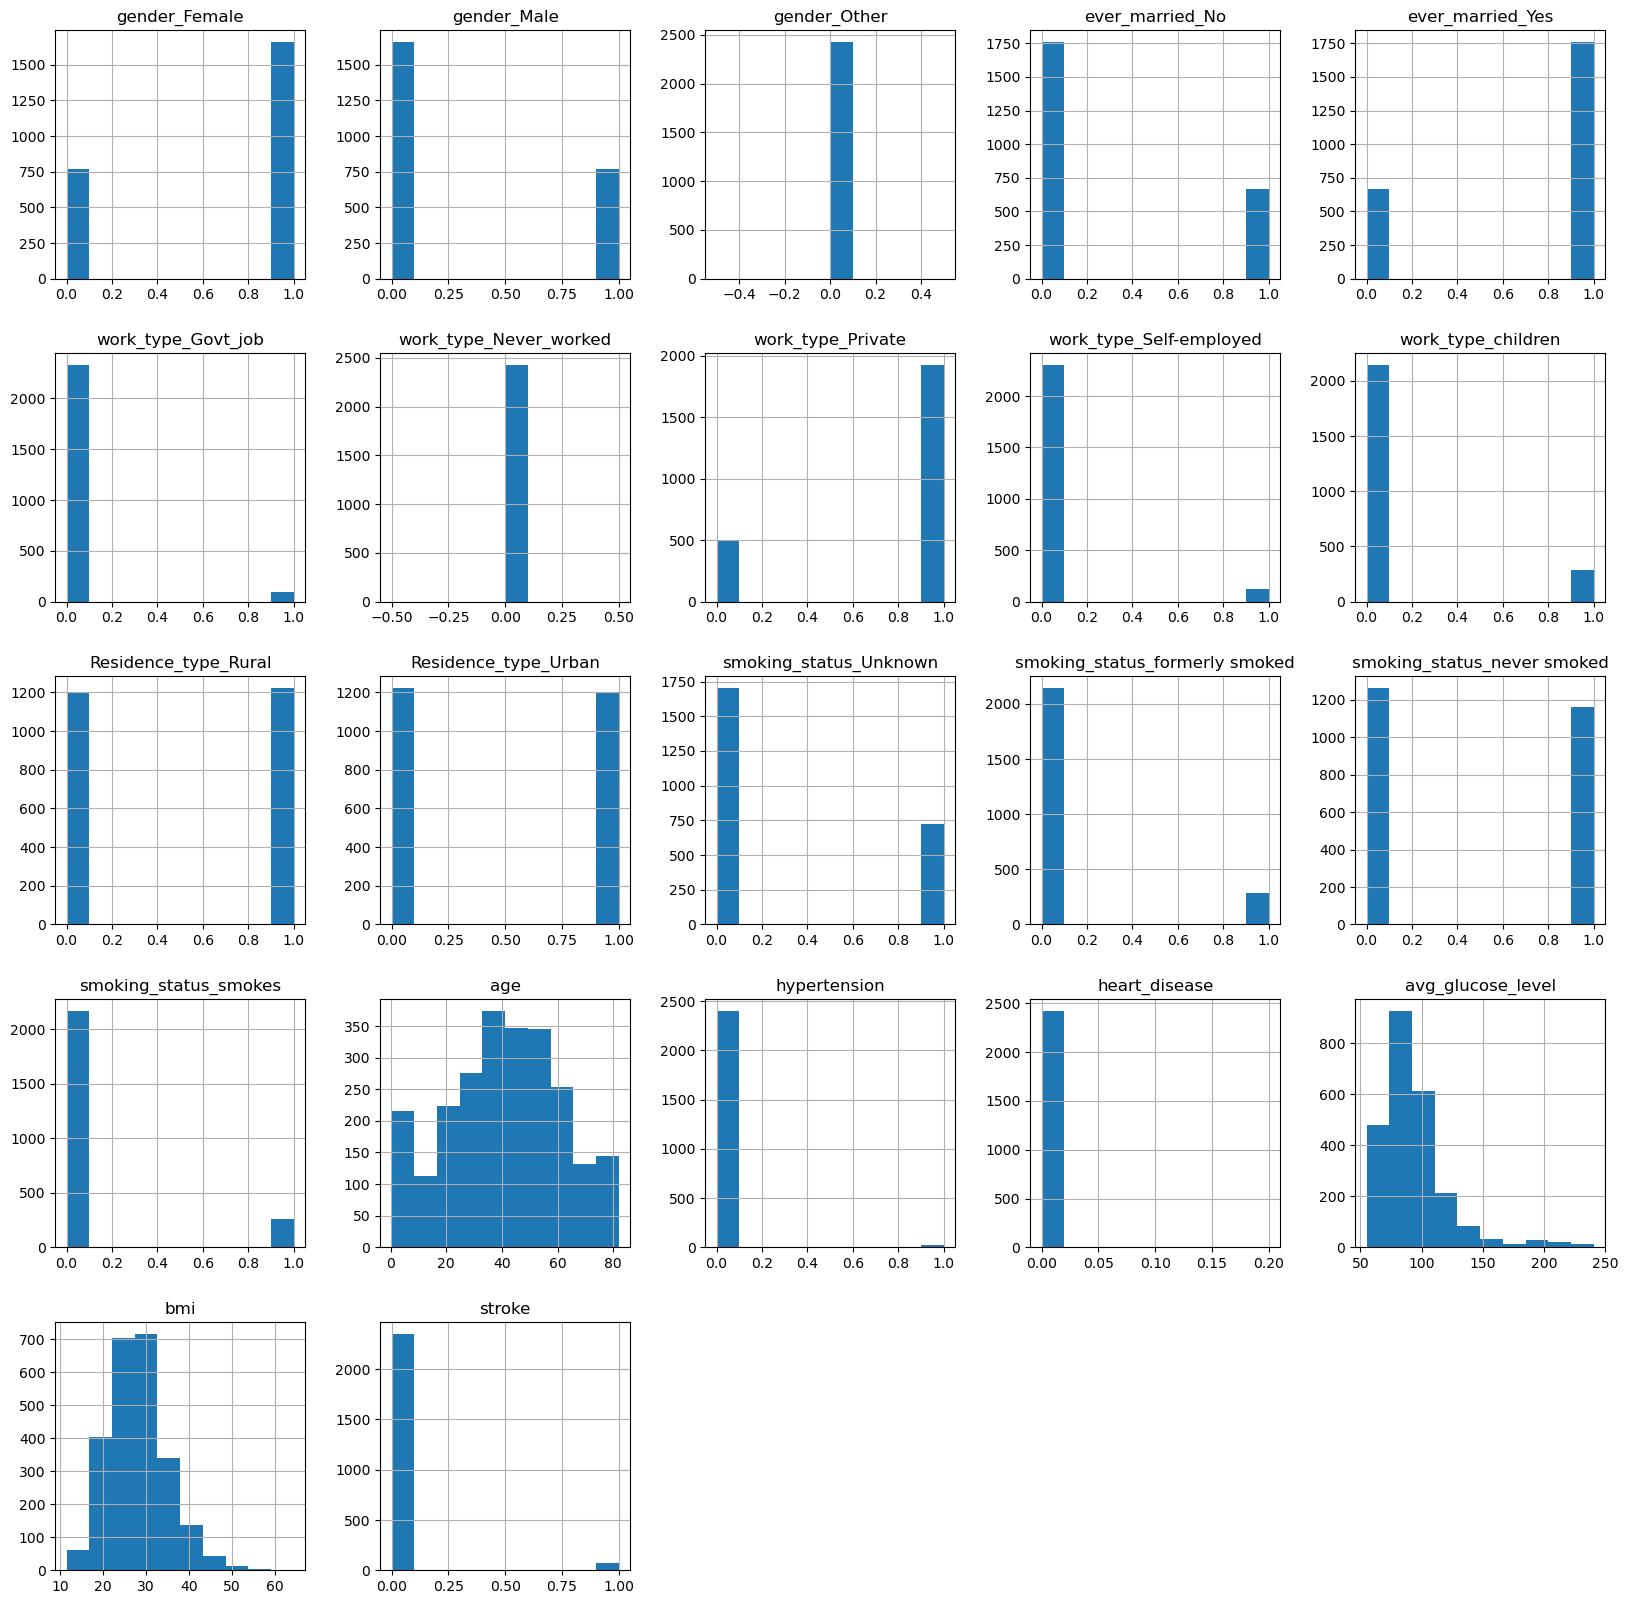

In [47]:
data_prepared_df.hist(figsize=(20, 20))
plt.show()

### Randomforest model with GridSearch paramentrs  

In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, 9, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.2, 0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = ['precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [53]:
rf_cv.fit(X_train_upsampled, y_train_upsampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, 9, None],
                         'max_features': [0.3, 0.6], 'max_samples': [0.2, 0.7],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['precision', 'recall', 'f1'])

In [54]:
rf_cv.best_score_

1.0

In [55]:
rf_cv.best_params_

{'max_depth': 7,
 'max_features': 0.3,
 'max_samples': 0.2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [56]:
y_pred = rf_cv.best_estimator_.predict(df_X_test_scaled)

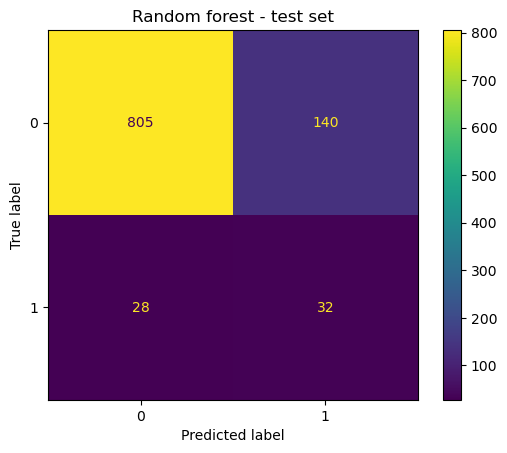

In [57]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

In [58]:
target_labels = ['no_stroke', 'stroke']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

   no_stroke       0.97      0.85      0.91       945
      stroke       0.19      0.53      0.28        60

    accuracy                           0.83      1005
   macro avg       0.58      0.69      0.59      1005
weighted avg       0.92      0.83      0.87      1005



## Feature importance

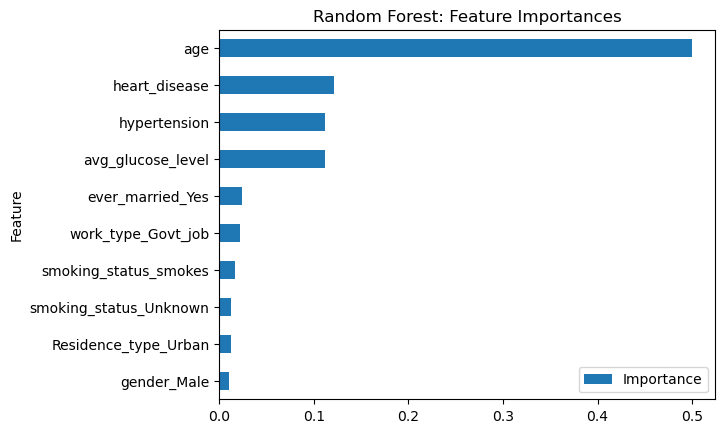

In [60]:
# Get feature importances
feat_impt = rf_cv.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf_cv.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances", fontsize=12)


plt.show()

Age is the most important feature for this classification task. For future model development, we could split age groups into several clusters.